# a3 - Python

This assignment will cover topics of classification and dimensionality reduction.

Make sure that you keep this notebook named as "a3-4821.ipynb" 

Any other packages or tools, outside those listed in the assignments or Canvas, should be cleared
by Dr. Brown before use in your submission.

# Q0 - Setup

The following code looks to see whether your notebook is run on Gradescope (GS), Colab (COLAB), or the linux Python environment you were asked to setup.

In [1]:
import re 
import os
import platform 
import sys 

# flag if notebook is running on Gradescope 
if re.search(r'amzn', platform.uname().release): 
    GS = True
else: 
    GS = False

# flag if notebook is running on Colaboratory 
try:
  import google.colab
  COLAB = True
except:
  COLAB = False

# flag if running on Linux lab machines. 
cname = platform.uname().node
if re.search(r'(guardian|colossus|c28|coc-15954-m)', cname):
    LLM = True 
else: 
    LLM = False

print("System: GS - %s, COLAB - %s, LLM - %s" % (GS, COLAB, LLM))

System: GS - False, COLAB - False, LLM - True


## Notebook Setup

It is good practice to list all imports needed at the top of the notebook. You can import modules in later cells as needed, but listing them at the top clearly shows all which are needed to be available / installed.

If you are doing development on Colab, the otter-grader package is not available, so you will need to install it with pip (uncomment the cell directly below).

In [2]:
# Only uncomment if you developing on Colab 
# if COLAB == True: 
#     print("Installing otter:")
#     !pip install otter-grader==4.2.0 

In [3]:
# Import standard DS packages 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import statistics
import textwrap
%matplotlib inline


from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import tree        # decision tree classifier
from sklearn import neighbors   # knn classifier
from sklearn import naive_bayes # naive bayes classifier 
from sklearn import svm         # svm classifier
from sklearn import ensemble    # ensemble classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics     # performance evaluation metrics
from sklearn import model_selection
from sklearn import preprocessing 
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA


# Package for Autograder 
import otter 
grader = otter.Notebook()

# Q1 - NBA Rookies

For this problem, you will go back to using the data set of rookie NBA players from 1980 - 2017 seasons.  The dataset was collected from the NBA website API - https://www.nba.com. 

You will use the data from their rookie year to predict whether a player will last at least 5 seasons in the leaque. 

The data consists of variables:

* `PlayerID`, `Player` - variables to identify individual samples (ignore for prediction)
* `Tm`, `Year` - variables describing the year the player started and for what team (ignore for prediction)  
* `TARGET` - This is the target / class feature to be predicted (whether the player was in the league for at least 5 years). 

The remaining variables are predictor variables for the models.  They come in pairs "*\_DIFF" and "*\_A" reporting the given statistic as the difference between Team A and Team B and the statistic itself for Team A. 

* `Pos` - position of the player, power forward, point guard, shooting guard, center, etc.
* `Age` - player age
* `G` - sum of number of games played
* `GS` - sum of number of games started
* `MP` - sum of number of minutes played
* `PTS` - sum of number of points scored
* `FG` - sum of number of field goals made (both 2 and 3 pointers)
* `FGA` - sum of number of field goals attempted
* `FG%` - FG / FGA, percentage of field goals made 
* `3P` - sum of the number of 3 pointers made
* `3PA` - sum of the number of 3 pointers attempted
* `3P%` - 3P / 3PA, percentage of 3 pointers made
* `2P` - sum of the number of 2 point shots made
* `2PA` - sum of the number of 2 point shots attempted
* `2P%` - 2P / 2PA, percentage of 2 point shots made
* `eFG%` - Effective Field Goal Percentage, (`FG` + 0.5 * `3P`)/`FGA`
* `FT` - sum of the number of free throws made
* `FTA` - sum of the number of free throws attempted
* `FT%` - FT / FTA, percentage of free throws made
* `ORB` - sum of the number of offensive rebounds
* `DRB` - sum of the number of defensive rebounds
* `TRB` - sum of the number of total rebounds
* `AST` - sum of the number of assists
* `STL` - sum of the number of steals
* `BLK` - sum of the number of blocks
* `TOV` - sum of the number of turnovers
* `PF` - sum of the number of personal fouls

More information on the stats used can be found: https://www.nba.com/stats/help/glossary   
*Note, some of the abbreviations used here are slightly different* 


## Q1(a) - Load Data, Handle Missing Data

**Same process as Q6(a) and Q6(c) on Assignment a2**

Load the `nba` data.

Next, you must handle the missing data. 

First, the missing values for GS, because there is not way to impute these values (and there are so few players in the 1980 and 1981 season having this information), the all samples from these two seasons should be deleted.

For the missing values in the "percentage" columns, replace those missing values with 0.

Call you new DataFrame after performing these operations nba2.


In [4]:
nba = pd.read_csv('nba_rookies.csv') 

nba2 = nba.copy()  # nba data with missing values handles. 
nba2.drop(nba2[(nba2['Year'] == 1980) | (nba2['Year'] == 1981)].index, inplace=True)
cols = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']
for col in cols:
    nba2[col] = pd.to_numeric(nba2[col], errors='coerce').fillna(0)

nba2.head()

,PlayerID,Player,Pos,Age,Tm,Year,G,GS,MP,PTS,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,TARGET
0,abdelal01,Alaa Abdelnaby,PF,22,POR,1991,43,0.0,290,135,...,0.568182,27,62,89,12,4,12,22,39,True
1,abdulma02,Mahmoud Abdul-Rauf,PG,21,DEN,1991,67,19.0,1505,942,...,0.857143,34,87,121,206,55,4,110,149,True
2,abdulta01,Tariq Abdul-Wahad,SG,23,SAC,1998,59,16.0,959,376,...,0.672000,44,72,116,51,35,13,65,81,True
3,abdursh01,Shareef Abdur-Rahim,PF,20,VAN,1997,80,71.0,2802,1494,...,0.745665,216,339,555,175,79,79,225,199,True
4,abrinal01,Álex Abrines,SG,23,OKC,2017,68,6.0,1055,406,...,0.897959,18,68,86,40,37,8,33,114,False


In [5]:
grader.check("q1a")

q1a results: All test cases passed!

## Q1(b) - Prepare the data 

**Same process as Q6(e) on Assignment a2**

At this point, we need to set up the data in order to be used in the classification models. 

We want to create a DataFrame `nbaX` for the predictor variables and `nbaY` for the target variable. 

The target variable, `nbaY` will just be the `Target` column of the `nba2` data set. 

The predictor variables have more considerations. 

We want to exclude player information such as IDs, `PlayerID` and names `Player`, that are identifying and not predictive.   

You should also exclude these other factors (note, that some of these variables may in fact be predictive but we are going to exclude at this time): 

* `POS` - player position
* `Tm` - team
* `Year` - rookie year
* `Age` - player age

Finally, several of the numeric predictive variables are not only related, but can be directly calculated from one another, e.g., `FG%` = `FG` / `FGA`.  Having variables that are closely related, or in this case redundant may actually hinder the predictive models. 

Therefore, exclude the following variables: `FG`, `3P`, `2P`, `eFG%`, `FT`, `TRB`. 

In [6]:
nbaY = nba2['TARGET']
nbaX = nba2.copy()

cols = ['PlayerID', 'Player', 'Age', 'Pos', 'Tm', 'Year', 'FG', '3P', '2P', 'eFG%', 'FT', 'TRB', 'TARGET']
nbaX.drop(columns=cols, inplace=True)

print(nbaX.shape)
print(nbaY.shape)

(2487, 19)
(2487,)


In [7]:
grader.check("q1b")

q1b results: All test cases passed!

## Q1(c) - Model Selection and Evaluation: Three-fold Split and Scaling

**Same process as Q6(f) on Assignment a2**



Split the data into training, validation and test sets with 60, 20, and 20% of the data respectively. Make sure to split the data such that the distribution of class labels is approximately equal across splits - “stratify”.

Set the seed for the random generator in `random_state` to ”4821”


In [8]:
# Split of the test set
X_trainval, X_test, y_trainval, y_test = train_test_split(nbaX, nbaY, test_size=0.2, random_state=4821, stratify=nbaY)

# Split trainval into train + val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=4821, stratify=y_trainval)

In [9]:
grader.check("q1c")

q1c results: All test cases passed!

## Q1(d) - Support Vector Machines + GridSearch with Cross-validation (without using GridSearchCV) 

In this part, you will use the *do-it-yourself* approach using `StratifiedKFold` (rather than GridSearchCV). 

Use the same split from above with 80% train+val, 20% test data. 

With the train+val data, use 10-fold cross-validation (make sure to use Stratified approach with random_state = 4821).  Train each model on the training set and evaluate each model on the validation set.  

*Consider how to do standard scaling with this approach.  That is, think about where you fit the parameters for scaling and then transform various parts of the data set.*  

You will consider SVM models with the following hyperparameters: 

* Polynomial kernel with C = [10^-2, 10^-1, 1], degree = [1, 2, 3], with `coef0 = 1`
* RBF kernel (Gaussian kernel) with C = [10^-2, 10^-1, 1] 

Collect each model's validation performance (AUC) in `svm_poly_auc_val` and `svm_rbf_auc_val` variables.  

Report the mean validation performance (AUC) as DataFrame with: 

- rows, Linear kernel, poly kernel d=2, poly kernel d=3, rbf kernel 
- columns, C = [10^-2, 10^-1, 1]

Report the best parameter combination (cost + kernel). 

Retrain the best model on train+val and report the test performance.  *Make sure to scale the train+val and test data, like it was done in Q6(g) in Assignment a2.*

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

# (Fold, C value, D value)
svm_poly_auc_val = np.zeros((10,3,3))

# (Fold, C value)
svm_rbf_auc_val = np.zeros((10,3))

# Hyperparameters
C_values = [10**-2, 10**-1, 1]
degree_values = [1, 2, 3]

# Setting up cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=4821)

# Loop for polynomial SVM
for i, C in enumerate(C_values):
    for j, degree in enumerate(degree_values):
        fold = 0
        for train_index, val_index in skf.split(X_trainval, y_trainval):
            X_train_fold, X_val_fold = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
            y_train_fold, y_val_fold = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

            # Scaling the data
            scaler = StandardScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)

            # Training the model
            svm_poly = SVC(kernel='poly', C=C, degree=degree, probability=True)
            svm_poly.fit(X_train_fold_scaled, y_train_fold)

            # Storing AUC value
            svm_poly_auc_val[fold, i, j] = roc_auc_score(y_val_fold, svm_poly.predict(X_val_fold_scaled))

            fold += 1
            
# Loop for RBF SVM
for i, C in enumerate(C_values):
    fold = 0
    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train_fold, X_val_fold = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train_fold, y_val_fold = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        # Scaling the data
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)

        # Training the model
        svm_rbf = SVC(kernel='rbf', C=C, probability=True)
        svm_rbf.fit(X_train_fold_scaled, y_train_fold)

        # Storing AUC value
        svm_rbf_auc_val[fold, i] = roc_auc_score(y_val_fold, svm_rbf.predict(X_val_fold_scaled))

        fold += 1

# Calculate mean validation performance (AUC) for each model
svm_results = pd.DataFrame({
    'C=10^-2': [
        np.mean(svm_poly_auc_val[:, 0, 0], axis = 0), 
        np.mean(svm_poly_auc_val[:, 0, 1], axis = 0), 
        np.mean(svm_poly_auc_val[:, 0, 2], axis = 0), 
        np.mean(svm_rbf_auc_val[:, 0], axis=0)
    ],
    'C=10^-1': [
        np.mean(svm_poly_auc_val[:, 1, 0], axis = 0), 
        np.mean(svm_poly_auc_val[:, 1, 1], axis = 0), 
        np.mean(svm_poly_auc_val[:, 1, 2], axis = 0), 
        np.mean(svm_rbf_auc_val[:, 1], axis=0)
    ],
    'C=1': [
        np.mean(svm_poly_auc_val[:, 2, 0], axis = 0), 
        np.mean(svm_poly_auc_val[:, 2, 1], axis = 0), 
        np.mean(svm_poly_auc_val[:, 2, 2], axis = 0), 
        np.mean(svm_rbf_auc_val[:, 2], axis=0)
    ]
}, index = ['Linear kernel', 'poly kernel d=2', 'poly kernel d=3', 'rbf kernel'])

# Find best hyperparameter combination
svm_best_auc = np.max(svm_results.values)
svm_best_indices = np.unravel_index(np.argmax(svm_results.values), svm_results.values.shape)
svm_bestC = C_values[svm_best_indices[1]]
svm_bestKernel = 'poly'
if svm_best_indices[0] == 0:
    svm_bestKernel = 'linear'
elif svm_best_indices[0] == 3:
    svm_bestKernel = 'rbf'
svm_bestD = svm_best_indices[0] + 1 

# Retrain the best model on train+val and report test performance
scaler_final = StandardScaler()
X_trainval_sc = scaler_final.fit_transform(X_trainval)
X_test_sc = scaler_final.transform(X_test)

svm_best = SVC(kernel=svm_bestKernel, C=svm_bestC, degree=svm_bestD, probability=True)
svm_best.fit(X_trainval_sc, y_trainval)

# Evaluate on test set
y_test_pred = svm_best.predict(X_test_sc)
svm_auc_test = roc_auc_score(y_test, y_test_pred)

print('best hyperparameters: %d, %s, %d' % (svm_bestC, svm_bestKernel, svm_bestD))
svm_results

best hyperparameters: 1, rbf, 4


,C=10^-2,C=10^-1,C=1
Linear kernel,0.722556,0.731693,0.730637
poly kernel d=2,0.589324,0.649746,0.681476
poly kernel d=3,0.655186,0.688683,0.713116
rbf kernel,0.725388,0.734733,0.735814


In [27]:
grader.check("q1d")

q1d results:
    q1d - 1 result:
        ❌ Test case failed
        Trying:
            np.isclose(svm_results.iloc[0, 0], 0.722556) and np.isclose(svm_results.iloc[1, 0], 0.730601)
        Expecting:
            True
        **********************************************************************
        Line 1, in q1d 0
        Failed example:
            np.isclose(svm_results.iloc[0, 0], 0.722556) and np.isclose(svm_results.iloc[1, 0], 0.730601)
        Expected:
            True
        Got:
            False

    q1d - 2 result:
        ❌ Test case failed
        Trying:
            np.isclose(svm_results.iloc[2, 0], 0.734758) and np.isclose(svm_results.iloc[3, 0], 0.725388)
        Expecting:
            True
        **********************************************************************
        Line 1, in q1d 1
        Failed example:
            np.isclose(svm_results.iloc[2, 0], 0.734758) and np.isclose(svm_results.iloc[3, 0], 0.725388)
        Expected:
            True
        Got:
            False

    q1d - 3 result:
        ❌ Test case failed
        Trying:
            np.isclose(svm_results.iloc[0, 1], 0.731187) and np.isclose(svm_results.iloc[1, 1], 0.734455)
        Expecting:
            True
        **********************************************************************
        Line 1, in q1d 2
        Failed example:
            np.isclose(svm_results.iloc[0, 1], 0.731187) and np.isclose(svm_results.iloc[1, 1], 0.734455)
        Expected:
            True
        Got:
            False

    q1d - 4 result:
        ❌ Test case failed
        Trying:
            np.isclose(svm_results.iloc[2, 1], 0.735173) and np.isclose(svm_results.iloc[3, 1], 0.734733)
        Expecting:
            True
        **********************************************************************
        Line 1, in q1d 3
        Failed example:
            np.isclose(svm_results.iloc[2, 1], 0.735173) and np.isclose(svm_results.iloc[3, 1], 0.734733)
        Expected:
            True
        Got:
            False

    q1d - 5 result:
        ❌ Test case failed
        Trying:
            np.isclose(svm_results.iloc[0, 2], 0.730637) and np.isclose(svm_results.iloc[1, 2], 0.732879)
        Expecting:
            True
        **********************************************************************
        Line 1, in q1d 4
        Failed example:
            np.isclose(svm_results.iloc[0, 2], 0.730637) and np.isclose(svm_results.iloc[1, 2], 0.732879)
        Expected:
            True
        Got:
            False

    q1d - 6 result:
        ❌ Test case failed
        Trying:
            np.isclose(svm_results.iloc[2, 2], 0.74083) and np.isclose(svm_results.iloc[3, 2], 0.735814)
        Expecting:
            True
        **********************************************************************
        Line 1, in q1d 5
        Failed example:
            np.isclose(svm_results.iloc[2, 2], 0.74083) and np.isclose(svm_results.iloc[3, 2], 0.735814)
        Expected:
            True
        Got:
            False

## Q1(e) -  Ensemble Methods + GridSearchCV with Pipelines

Let’s examine bagging & boosting ensemble approaches for prediction.

For this part, we will use the **preferred method for building predictor models by using pipelines**. 

You will create a pipeline for the Random Forest models and a pipeline for the AdaBoost models. Both pipelines will use standard scaling preprocessing.  Label the steps of the pipeline with "sc" for the scaling step and "rf" and "ab" for the modeling step in the two different pipelines.

For the random forest, consider hyper-parameters for the maximum number of features: [2, 4, 8, 16] and number of estimators of [25, 50, 100].  For AdaBoost, consider the hyper-parameter of the number of estimators as [10, 25, 50, 100]. 

To ensure repeatability or your code (and to compare to the autograder) make sure to set the random state in both classifiers and the stratified 10-fold cross-validation to "4821".  

Use AUC as the scoring metric for the GridSearch criteria.  

You will need to report the best hyper-parameters for both models as well as the final test set performance. 


In [31]:
# You will create a pipeline for both the Random Forest and AdaBoost models. 
#   Both pipelines will use standard scaling preprocessing. 
#   Call the scaling step "sc" and model step for each pipeline, "rf" / "ab" 
#   Set the random state in both classifiers to 4821
ab_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('ab', AdaBoostClassifier(random_state=4821))
])

rf_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=4821))
]) 

# RF: hyper-parameters for the maximum number of features: [2, 4, 8, 16] and 
#   number of estimators of [25, 50, 100].  
rf_params = {
    'rf__max_features': [2, 4, 8, 16],
    'rf__n_estimators': [25, 50, 100]
}

# AdaBoost: hyper-parameter of the number of estimators as [10, 25, 50, 100].
ab_params = {
    'ab__n_estimators': [10, 25, 50, 100]
}

# Set the random state in the stratified k-fold cv to 4821  
cvStrat = StratifiedKFold(n_splits=10, shuffle=True, random_state=4821) 

# Use AUC as the scoring metric for the GridSearch criteria. 
rf_grid = GridSearchCV(rf_pipe, param_grid=rf_params, scoring='roc_auc', cv=cvStrat) 
ab_grid = GridSearchCV(ab_pipe, param_grid=ab_params, scoring='roc_auc', cv=cvStrat)

# Fit the grid search objects
rf_grid.fit(X_trainval, y_trainval)
ab_grid.fit(X_trainval, y_trainval)

# Report the best hyper-parameters and final test set performance 
rf_best_params = rf_grid.best_params_
ab_best_params = ab_grid.best_params_

rf_auc_test = roc_auc_score(y_test, rf_grid.best_estimator_.predict(X_test))
ab_auc_test = roc_auc_score(y_test, ab_grid.best_estimator_.predict(X_test))


In [32]:
grader.check("q1e")

q1e results: All test cases passed!

## Q1(f) - Feature Selection 

Now that you have explored several different classification models and how to create pipelines, let's explore create a pipeline that considers different scaling methods, feature selection options, and models in a pipeline. 

Specifically, you will create a pipeline that considers the following steps using the labels below. 

* Scaling - `scaler`
    * MinMaxScaling with default values
    * StandardScaling with the default values
* Feature Selection - `feat_sel`
    * Use `SelectPercentile` as a way to select features
    * For the `SelectPercentile` consider 10, 25, 50, 75, and 100% of your data, use the `f_classif` option to select the features
* Classification Models - `classify`
    * Consider a KNN model with k = [11, 15, 19]
    * Consider a Random Forest model with number of trees [10, 25, 50] and max_features in [2, 8, 16]
    * Consider an AdaBoost model with number of estimators of [10, 25, 50]
 
To ensure repeatability or your code (and to compare to the autograder) make sure to set the random state in the Random Forest and AdaBoost classifiers and the stratified 10-fold cross-validation to "4821".  

Use AUC as the scoring metric for the GridSearch criteria.  

You will need to report the best hyper-parameters as well as the final test set performance. 


In [32]:

#  you will create a pipeline that considers the following steps
#    - Scaling - labeled `scaler`
#    - Feature Selection - labeled `feat_sel`
#    - Classification model - labeled `classify`

final_pipe = ... 

# Consider the following hyperparameters for each step:
#  (you may need to create a list of dictionaries to store the options) 
# * Scaling - `scaler`
#     * MinMaxScaling with default values
#     * StandardScaling with the default values
# * Feature Selection - `feat_sel`
#     * Use `SelectPercentile` as a way to select features
#     * For the `SelectPercentile` consider 10, 25, 50, 75, and 100% of the data
#         use the `f_classif` option to select the features
# * Classification Models - `classify`
#     * Consider a KNN model with k = [11, 15, 19]
#     * Consider a Random Forest model with number of trees [10, 25, 50] and 
#          max_features in [2, 5, 10, 15]
#     * Consider an AdaBoost model with number of estimators of [10, 25, 50]

final_params = ...


# Set the random state in the stratified k-fold cv to 4821  
cvStrat = ... 

# Use AUC as the scoring metric for the GridSearch criteria. 
final_grid = ... 


# Report the best hyper-parameters and final test set performance 
final_best_params = ...

final_auc_test = ...

print(final_best_params)
print(final_auc_test)

Ellipsis
Ellipsis


In [33]:
grader.check("q1f")

q1f results:
    q1f - 1 result:
        ❌ Test case failed
        Trying:
            np.isclose(final_auc_test, 0.75391986)
        Expecting:
            True
        **********************************************************************
        Line 1, in q1f 0
        Failed example:
            np.isclose(final_auc_test, 0.75391986)
        Exception raised:
            Traceback (most recent call last):
              File "/home/campus14/dmmunson/.conda/envs/cs4821/lib/python3.10/doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q1f 0[0]>", line 1, in <module>
                np.isclose(final_auc_test, 0.75391986)
              File "/home/campus14/dmmunson/.conda/envs/cs4821/lib/python3.10/site-packages/numpy/core/numeric.py", line 2348, in isclose
                xfin = isfinite(x)
            TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

    q1f - 2 result:
        ❌ Test case failed
        Trying:
            str(final_best_params['scaler']).startswith('MinMax')
        Expecting:
            True
        **********************************************************************
        Line 1, in q1f 1
        Failed example:
            str(final_best_params['scaler']).startswith('MinMax')
        Exception raised:
            Traceback (most recent call last):
              File "/home/campus14/dmmunson/.conda/envs/cs4821/lib/python3.10/doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q1f 1[0]>", line 1, in <module>
                str(final_best_params['scaler']).startswith('MinMax')
            TypeError: 'ellipsis' object is not subscriptable

# Q2 - Pokemon Data 

Consider the following data set of Pokemon (collected from several sources, pokemon.com, pokemondb, bulbapedia). 



## Q2(a) - Load the data 

Load the Pokemon data into a Data Frame, `pok`, consider how to read in missing data.

In [33]:
# Read in Pokemon data
pok = pd.read_csv("pokemon.csv")

pok.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


In [34]:
grader.check("q2a")

q2a results: All test cases passed!

<!-- BEGIN QUESTION -->

## Q2(b) - Explore the Data 

Look at the distribution of Pokemon skills we will use in this analysis: `hp`, `attack`, `defense`, `sp_attack` - Special Attack, `sp_defense` - Special Defense, and `speed`. 

Create a violinplot showing the distribution of these variables. 


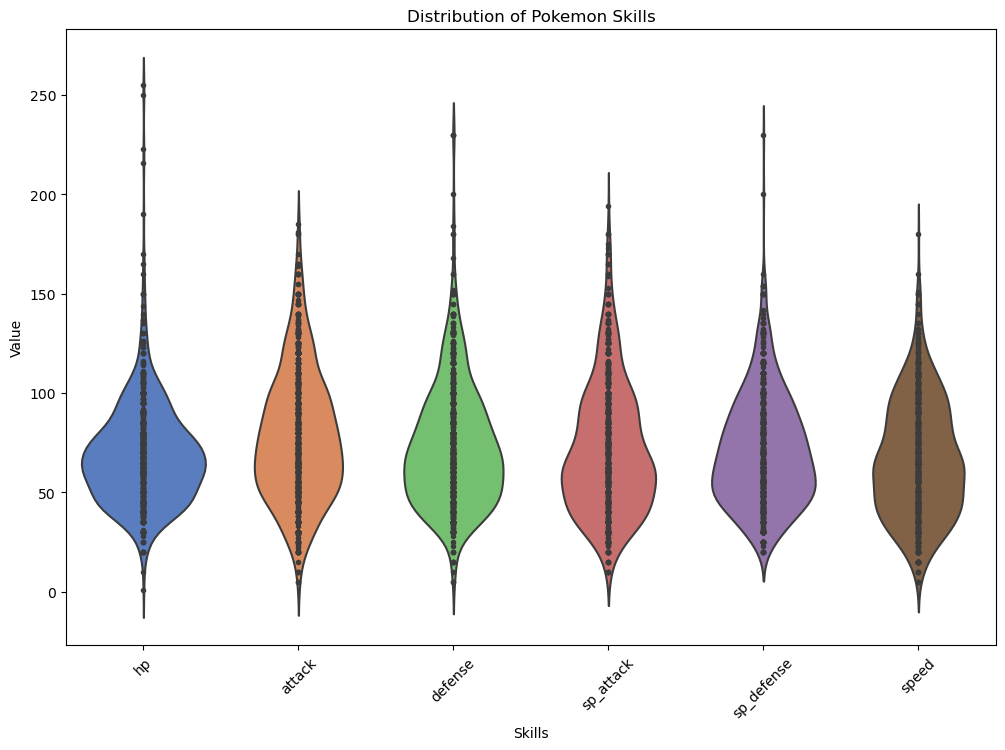

In [35]:
# Select the columns for the skills
skills = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']

# Create a violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(data=pok[skills], palette="muted", inner="points")
plt.title("Distribution of Pokemon Skills")
plt.xlabel("Skills")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()

<!-- END QUESTION -->

## Q2(c) - Prepare the data 

Let's use the 6 pokemon skills viewed above.  

The six features (Pokemon Skills) have different ranges, therefore we should scale the data before considering PCA. Standardize the data over the six features of interest, store only these variables in `pokScaled` DataFrame.

In [36]:
# Create a DataFrame with only the selected skills
pokSkills = pok[skills]

# Standardize the data
scaler = StandardScaler()
pokScaled = scaler.fit_transform(pokSkills)

# Convert the standardized data to a NumPy array
pokScaled = np.array(pokScaled)

In [37]:
grader.check("q2c")

q2c results: All test cases passed!

## Q2(d) - Principal Components Analysis 

Perform principal components analysis (PCA) on the scaled Pokemon skills data. 
Store the results of PCA in `pokPCA` and the transformed data in `pokTr`.

In [38]:
# Run PCA on the scaled data
pca = PCA()
pokPCA = pca.fit(pokScaled)

# Transform the data
pokTr = pca.transform(pokScaled)

# Display the shape of the components


In [39]:
grader.check("q2d")

q2d results: All test cases passed!

<!-- BEGIN QUESTION -->

## Q2(e) - Explore the Results 

Plot the transformed data in the space defined by the first two principal components. This should be a scatterplot.

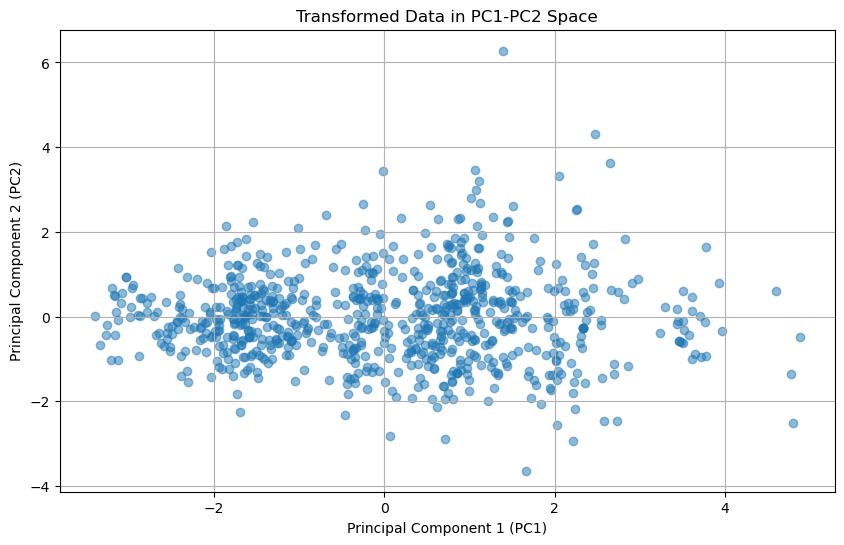

In [40]:
# Run PCA on the scaled data
pca = PCA(n_components=2)
pokPCA = pca.fit_transform(pokScaled)

# Plot the transformed data
plt.figure(figsize=(10, 6))
plt.scatter(pokPCA[:, 0], pokPCA[:, 1], alpha=0.5)  # Access PC1 and PC2 directly from the pokPCA array
plt.title('Transformed Data in PC1-PC2 Space')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.grid(True)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Q2(f) - Explore the Results, part 2 

Explore the amount of variance explained by each principal component direction. Plot the proportion of variance explained (y-axis) vs. the different principal components.

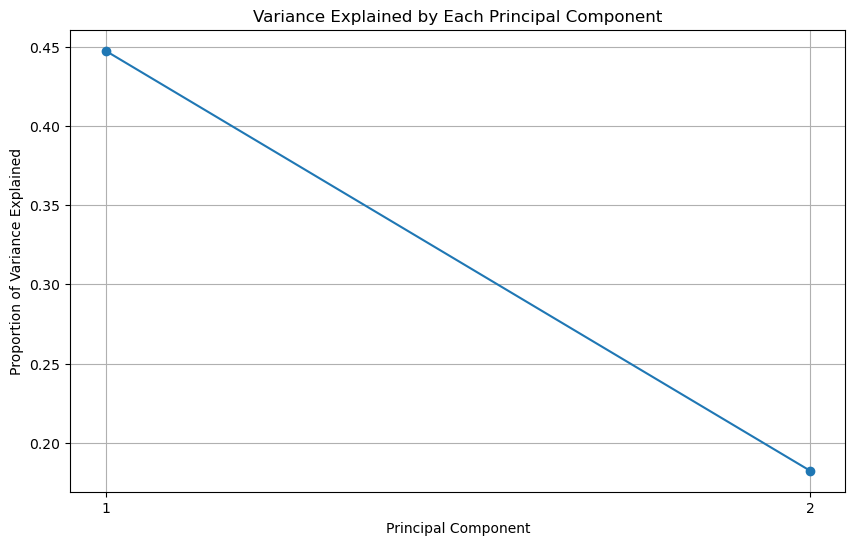

In [41]:
# Plot variance explained by each component   

# Plot variance explained by each component
plt.figure(figsize=(10, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('Variance Explained by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1, pca.n_components_ + 1))
plt.grid(True)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Q2(g) - Explore the Results, part 3

Plot the cumulative proportion of variance explained by the principal components.


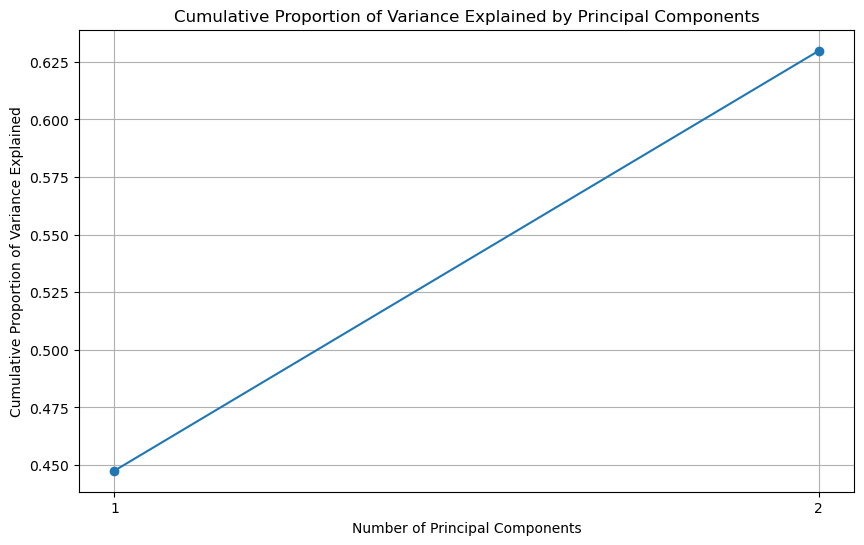

In [42]:
# Plot the cumulative variance explained.   

# Calculate cumulative proportion of variance explained
cumulative_var_ratio = pca.explained_variance_ratio_.cumsum()

# Plot cumulative proportion of variance explained
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='o', linestyle='-')
plt.title('Cumulative Proportion of Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.xticks(range(1, len(cumulative_var_ratio) + 1))
plt.grid(True)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Q2 bonus 

Display the transformed data in the space defined by the first two principal components.  Let's also color the data points by `type1`.  Place the legend outside the plot to the right. 



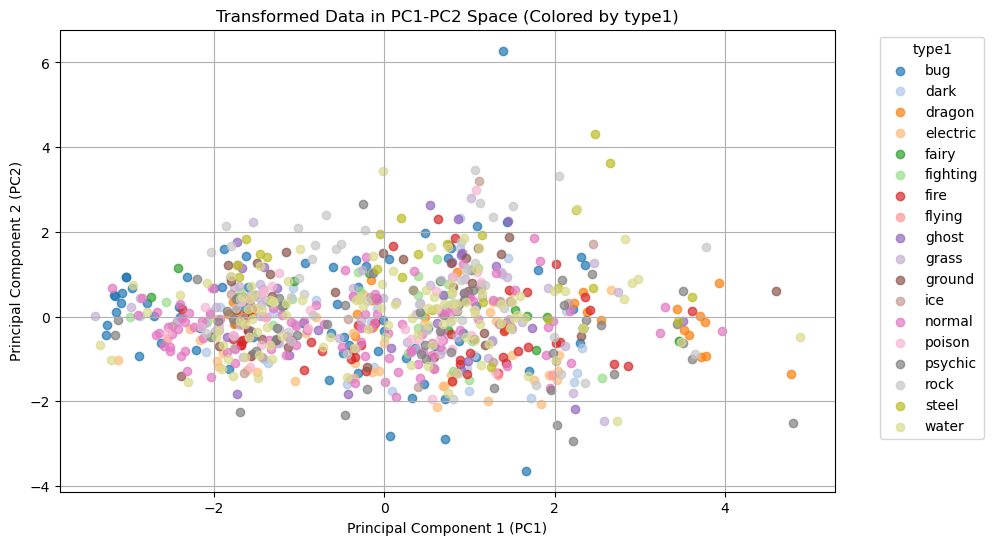

In [43]:
# Create a DataFrame for the transformed data
pokTr = pd.DataFrame(data=pokPCA, columns=['PC1', 'PC2'])

# Combine transformed data with 'type1' column
pokTr['type1'] = pok['type1']

# Plot the transformed data with colored points by 'type1'
plt.figure(figsize=(10, 6))
num_types = len(pok['type1'].unique())
colors = plt.cm.tab20.colors[:num_types]  # Get colors for each unique 'type1'
for i, (type1, group) in enumerate(pokTr.groupby('type1')):
    plt.scatter(group['PC1'], group['PC2'], color=colors[i], label=type1, alpha=0.7)

# Add labels and legend
plt.title('Transformed Data in PC1-PC2 Space (Colored by type1)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend(title='type1', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

<!-- END QUESTION -->

# Q3 - Polarization of Congress 

For this part of the project you will consider methods to group members of U.S. House of Representatives based on their voting records. The voting records from congress are available at Office of the Clerk, US House of Representatives, but not in a form that is easily digestible for analysis.

In fact it was only in 2016, that Congress agreed to make legislative data available themselves. Govtrack.us has links to primary data sources and api’s projects that collect and release the data in easier digestible forms.

A long-standing project to document congressional roll call votes at the Interuniversity Consortium for Political and Social Research (ICPSR). This data includes roll call votes from 1789 - 1990. The ICPSR formatting for storing this data has been used on other sites which are keeping up with the creating a record.

The data you will use was downloaded in its raw state from https://voteview.com/data. Then, for each of the last 20 congresses (up until 2021), 50 random votes were selected for each member (ignoring the first 10 votes of each session - these votes usually have to do with electing a Speaker of the House and rules votes). The results are stored in the the files `H97_votes.csv`, `H98_votes.csv`, ..., `H116_votes.csv`.


References: 
- http://clerk.house.gov/legislative/legvotes.aspx
- https://www.icpsr.umich.edu/icpsrweb/ICPSR/series/159

## Q3(a) - Load and prepare the data 

Working with data for the 116th Congress, H116 votes.csv, read in the vote data. 

Preprocess the data appropriately. 



In [54]:
# Read in votes data into DataFrame 
votes = pd.read_csv("congress/H116_votes.csv")

# prepare the data for PCA 
# Scaled votes data only
votes_sc = votes.drop(votes.columns[:8], axis=1)


(439, 58)
(439, 58)
(439, 50)


In [53]:
grader.check("q3a")

q3a results:
    q3a - 1 result:
        ✅ Test case passed

    q3a - 2 result:
        ✅ Test case passed

    q3a - 3 result:
        ❌ Test case failed
        Trying:
            all(np.isclose(votes_sc[4:6, 3:7], np.array([[0.96619664, 1.03995153, -0.18356312, -0.17495795], [0.96619664, 1.03995153, -0.18356312, -0.17495795]])).flatten())
        Expecting:
            True
        **********************************************************************
        Line 1, in q3a 2
        Failed example:
            all(np.isclose(votes_sc[4:6, 3:7], np.array([[0.96619664, 1.03995153, -0.18356312, -0.17495795], [0.96619664, 1.03995153, -0.18356312, -0.17495795]])).flatten())
        Exception raised:
            Traceback (most recent call last):
              File "/home/campus27/clwilfon/.conda/envs/cs4821/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3791, in get_loc
                return self._engine.get_loc(casted_key)
              File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc
              File "index.pyx", line 158, in pandas._libs.index.IndexEngine.get_loc
            TypeError: '(slice(4, 6, None), slice(3, 7, None))' is an invalid key

            During handling of the above exception, another exception occurred:

            Traceback (most recent call last):
              File "/home/campus27/clwilfon/.conda/envs/cs4821/lib/python3.10/doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q3a 2[0]>", line 1, in <module>
                all(np.isclose(votes_sc[4:6, 3:7], np.array([[0.96619664, 1.03995153, -0.18356312, -0.17495795], [0.96619664, 1.03995153, -0.18356312, -0.17495795]])).flatten())
              File "/home/campus27/clwilfon/.conda/envs/cs4821/lib/python3.10/site-packages/pandas/core/frame.py", line 3893, in __getitem__
                indexer = self.columns.get_loc(key)
              File "/home/campus27/clwilfon/.conda/envs/cs4821/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3803, in get_loc
                self._check_indexing_error(key)
              File "/home/campus27/clwilfon/.conda/envs/cs4821/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 5975, in _check_indexing_error
                raise InvalidIndexError(key)
            pandas.errors.InvalidIndexError: (slice(4, 6, None), slice(3, 7, None))

## Q3(b) - PCA 

Perform principal component analysis on the voting records.  

Plot the first two principal components. Because we know the party affiliation of each member of congress, color the plot based on party (red = Republican, PartyCode=200; blue = Democrat, PartyCode = 100; green = Independent, PartyCode in 300s).

In [ ]:

# Run PCA and transform the data 

votes_pca = ...
votes_tr = ...

# Create plot


In [ ]:
grader.check("q3b")

<!-- BEGIN QUESTION -->

## Q3(c) - Historical Polarization (bonus)

Create a small multiples plot (6 x 3) showing the results of PCA (colored by party) for the 18 Congresses starting with the 97th.

In [ ]:
# Create small multiples plot



<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

**NOTE** the submission must be run on the campus linux machines.  See the instruction in the Canvas assignment.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)